In [268]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import scipy as sp

In [269]:
np.show_config()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: C:/Users/kdarn/anaconda3/envs/TenseNeuralNets/Library/include
    lib directory: C:/Users/kdarn/anaconda3/envs/TenseNeuralNets/Library/lib
    name: mkl-sdl
    openblas configuration: unknown
    pc file directory: C:\b\abs_7267ja_mqz\croot\numpy_and_numpy_base_1701295083047\_h_env\Library\lib\pkgconfig
    version: '2023.1'
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep1610466607184
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  c++:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.0
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x8

In [270]:
def periodic_boundary(index, num_grid_points):
        if index < num_grid_points/2:
            return 2*index
        else:
            return 2*(num_grid_points-index)-1

In [271]:
def index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points):
        return periodic_boundary(index_i, num_i_grid_points) * num_j_grid_points + periodic_boundary(index_j, num_j_grid_points)

In [272]:
def index_periodic_boundary_backward_converter(Periodic_L_index, Periodic_L_indices,num_j_grid_points):
        index_i, index_j = Periodic_L_indices[Periodic_L_index]
        L_index = index_i * num_j_grid_points + index_j
        return L_index

In [273]:
num_i_grid_points = 70
num_j_grid_points = 70
Final_Time = 10.0
Num_Timesteps = 100
num_grid_points = num_i_grid_points * num_j_grid_points

In [274]:
dTheta = (2*np.pi)/(num_i_grid_points)
dZeta = (2*np.pi)/(num_j_grid_points)
dTime = (Final_Time)/(Num_Timesteps)
print(dTheta, dZeta, dTime, Num_Timesteps)
print(num_i_grid_points, num_j_grid_points, Final_Time, Num_Timesteps)

0.08975979010256552 0.08975979010256552 0.1 100
70 70 10.0 100


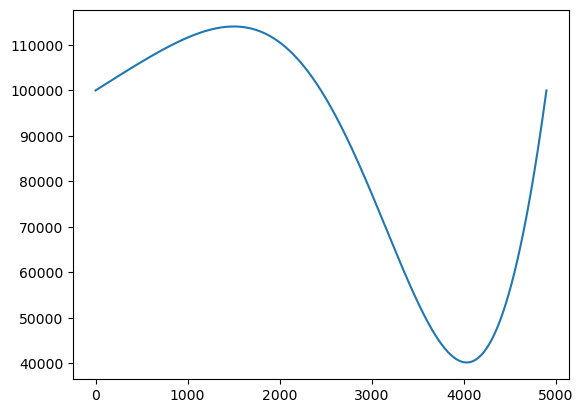

In [275]:
Q_11 = 100 * np.ones(shape = (num_grid_points,))
Q_22 = 100 * np.ones(shape = (num_grid_points,))
Q_12 = 100 * np.ones(shape = (num_grid_points,))
Resvoir = 1e2 * np.ones(shape  = (num_grid_points,))
Source  = 1e5 * np.ones(shape = (num_grid_points,)) + 1e4*np.array([np.sin(x)*np.cosh(x/2) for x in np.linspace(0,2*np.pi, num_grid_points)])
plt.plot(Source)

In [276]:
Temperatures_Solution = np.zeros((num_grid_points,))
Temperature_Grid = []
phi = np.zeros((num_grid_points,))
b = np.zeros((num_grid_points,))

In [277]:
Periodic_L_indices = np.zeros((num_grid_points, 2), dtype = np.int64)
index_a = 0
while index_a <= num_i_grid_points -1:
    index_b = 0
    while index_b <= num_j_grid_points -1:
        Periodic_L_indices[index_periodic_boundary_forward_converter(index_a,index_b, num_i_grid_points, num_j_grid_points)] = (int(index_a),int(index_b))
        index_b +=1
    index_a +=1
Periodic_L_indices.shape

(4900, 2)

In [278]:
m = 1000
ab = np.zeros((3,m))
b = 2*np.ones(m)
ab[0] = 9
ab[1] = 8
ab[2] = 7

# Fix end points
ab[0,1] = 2
ab[1,0] = 1
ab[1,-1] = 4
ab[2,-2] = 3
b[0] = 1
b[-1] = 3
ab

array([[9., 2., 9., ..., 9., 9., 9.],
       [1., 8., 8., ..., 8., 8., 4.],
       [7., 7., 7., ..., 7., 3., 7.]])

In [279]:
nbands_below = 3*num_i_grid_points - 1
nbands_above = nbands_below
def MatrixCreator(num_i_grid_points, num_j_grid_points, dt, \
                     di, dj, Q_11, Q_22, Q_12, Resvoir, ncols, nbands_above):
        
        def get_index(row, column, nbands_upper, n_columns):
            band_row = nbands_upper + row - column 
            if row < 0 or column < 0 or row >= n_columns or column >= n_columns:
                raise IndexError("Indexes out of bounds in get_index: {} {}".format(row, column))
            return band_row, column
    
        def set_value(band_matrix,row, column, value, nbands_upper):
        # Calculate the correct row in the band_matrix
            band_row = nbands_upper + row - column
            if band_row < 0 or band_row >= band_matrix.shape[0]:
                return IndexError("Indexes out of bounds in get_value: {} {}".format(row, column)) # Ignore values that are outside the band width
            return band_row, column, value

        def get_value(band_matrix, row, column, nbands_upper):
            band_row = nbands_upper + row - column
            if band_row < 0 or band_row >= band_matrix.shape[0]:
                raise IndexError("Indexes out of bounds in get_value: {} {}".format(row, column))
            return band_matrix[band_row, column]

        index_plus_i = 0
        index_minus_i = 0
        index_plus_j = 0
        index_minus_j = 0
        index_i = 0
        
        coefficient_matrix = np.zeros((ncols, ncols))
        nbrows = nbands_below + nbands_above + 1
        ncols = num_grid_points
        banded_coefficient_matrix = np.zeros((nbrows, ncols))
        while index_i < num_i_grid_points:

            if index_i ==0:
                index_minus_i = num_i_grid_points - 1
            else:
                index_minus_i = index_i -1

            if index_i == num_i_grid_points:
                index_plus_i = 0
            else:
                index_plus_i = index_i + 1
        
            index_j = 0
            while index_j < num_j_grid_points:
            
                if index_j ==0:
                    index_minus_j = num_j_grid_points - 1
                else:
                    index_minus_j = index_j -1

                if index_j == num_j_grid_points:
                    index_plus_j = 0
                else:
                    index_plus_j = index_j + 1

                index_current = index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)

                coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_plus_i, index_j, num_i_grid_points, num_j_grid_points)] = (-Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*di**2)
                band_row, column, value = set_value(banded_coefficient_matrix, index_current, index_periodic_boundary_forward_converter(index_plus_i, index_j, num_i_grid_points, num_j_grid_points), coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_plus_i, index_j, num_i_grid_points, num_j_grid_points)], nbands_above)
                banded_coefficient_matrix[band_row, column] = value

                coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_plus_j, num_i_grid_points, num_j_grid_points)] = (-Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*dj**2)
                band_row, column, value = set_value(banded_coefficient_matrix, index_current, index_periodic_boundary_forward_converter(index_i, index_plus_j, num_i_grid_points, num_j_grid_points), coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_plus_j, num_i_grid_points, num_j_grid_points)], nbands_above)
                banded_coefficient_matrix[band_row, column] = value

                coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] = (Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] *(dt)/(2*di**2) + Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt)/(2*dj**2) + Resvoir[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)]*(dt/2) + 1)
                band_row, column, value = set_value(banded_coefficient_matrix, index_current, index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points), coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)], nbands_above)
                banded_coefficient_matrix[band_row, column] = value

                coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_minus_i, index_j, num_i_grid_points, num_j_grid_points)] = (-Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*di**2)
                band_row, column, value = set_value(banded_coefficient_matrix, index_current, index_periodic_boundary_forward_converter(index_minus_i, index_j, num_i_grid_points, num_j_grid_points), coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_minus_i, index_j, num_i_grid_points, num_j_grid_points)], nbands_above)
                banded_coefficient_matrix[band_row, column] = value

                coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_minus_j, num_i_grid_points, num_j_grid_points)] = (-Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*dj**2)
                band_row, column, value = set_value(banded_coefficient_matrix, index_current, index_periodic_boundary_forward_converter(index_i, index_minus_j, num_i_grid_points, num_j_grid_points), coefficient_matrix[index_current, index_periodic_boundary_forward_converter(index_i, index_minus_j, num_i_grid_points, num_j_grid_points)], nbands_above)
                banded_coefficient_matrix[band_row, column] = value

                index_j +=1
            index_i +=1

        return coefficient_matrix, banded_coefficient_matrix

In [280]:
def phi_generator(num_i_grid_points, num_j_grid_points, dt, di, dj, Q_11, Q_12, Q_22, Resvoir, phi, Temperatures_Solution):
    
        index_plus_i = 0
        index_minus_i = 0
        index_plus_j = 0
        index_minus_j = 0

        index_i = 0
        while index_i <= num_i_grid_points-1:

            if index_i ==0:
                index_minus_i = num_i_grid_points - 1
        
            else:
                index_minus_i = index_i -1

            if index_i == num_i_grid_points:
                index_plus_i = 0
            else:
                index_plus_i = index_i + 1
        
            index_j = 0
            while index_j <= num_j_grid_points -1:
            
                if index_j ==0:
                    index_minus_j = num_j_grid_points - 1
        
                else:
                    index_minus_j = index_j -1

                if index_j == num_j_grid_points:
                    index_plus_j = 0
                else:
                    index_plus_j = index_j + 1

                contribution_0 = ((Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*di**2)) * Temperatures_Solution[index_periodic_boundary_forward_converter(index_plus_i, index_j, num_i_grid_points, num_j_grid_points)]
                contribution_1 = ((Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*dj**2)) * Temperatures_Solution[index_periodic_boundary_forward_converter(index_i, index_plus_j, num_i_grid_points, num_j_grid_points)]
                contribution_2 = -1.0 * (Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] *(dt)/(2*di**2) + Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt)/(2*dj**2) + Resvoir[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)]*(dt/2) - 1) * Temperatures_Solution[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)]
                contribution_3 = ((Q_11[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*di**2)) * Temperatures_Solution[index_periodic_boundary_forward_converter(index_minus_i, index_j, num_i_grid_points, num_j_grid_points)]
                contribution_4 = ((Q_22[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] * (dt))/(4*dj**2)) * Temperatures_Solution[index_periodic_boundary_forward_converter(index_i, index_minus_j, num_i_grid_points, num_j_grid_points)]

                phi[index_periodic_boundary_forward_converter(index_i, index_j, num_i_grid_points, num_j_grid_points)] = contribution_0 + contribution_1 + contribution_2 + contribution_3 + contribution_4
                index_j +=1
            index_i +=1
        return phi

In [281]:
coefficient_matrix, banded_coefficient_matrix = MatrixCreator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_22, Q_12, Resvoir, num_grid_points, nbands_above)
print(coefficient_matrix.shape, banded_coefficient_matrix.shape)

(4900, 4900) (419, 4900)


In [284]:
for index_i in range(70):
    for index_j in range(70):
        if index_j == 0:
            print("|", end = "")
        element = coefficient_matrix[index_i, index_j]
        print(f"%.3f" % element, end = " ")
    print("|", end = "\n")

|1247.184 -310.296 -310.296 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 |
|0.000 1247.184 0.000 -310.296 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 |
|-310.296 0.000 1247.184 0.000 -310.296 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.0

In [285]:
def Band_Matrix_Creator(coefficient_matrix):
    n = coefficient_matrix.shape[0]
    upper_band = np.zeros((2, num_grid_points))
    lower_band = np.zeros((2, num_grid_points))
    main_diag = np.diag(coefficient_matrix)
    
    upper_band[0, 1:] = np.diag(coefficient_matrix, k = 1)
    upper_band[1,-1] = coefficient_matrix[0,-2]
    lower_band[0,:-1] = np.diag(coefficient_matrix, k = -1)
    lower_band[1,0] = coefficient_matrix[-1,1]

    banded_matrix = np.vstack((upper_band, main_diag, lower_band))
    return banded_matrix

In [137]:
time_index = 0
coefficient_matrix, banded_coefficient_matrix = MatrixCreator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_22, Q_12, Resvoir, num_grid_points, nbands_above)
coefficient_matrix_sparse = sp.csr_matrix(coefficient_matrix)
while time_index <= Num_Timesteps:
        print("Time_Iteration",time_index)

        Temperatures_Solution = np.zeros((num_grid_points,))
        Temperature_Grid_dt = np.zeros((num_grid_points,))
        
        b = phi + 2.0*Source

        #print(coefficient_matrix)
        
       
        #Temperatures_Solution = np.linalg.solve(coefficient_matrix, b)/
        Temperatures_Solution = sp.sparse.linalg.spsolve(coefficient_matrix_sparse, b)
        #Temperatures_Solution = sp.linalg.solve_banded((nbands_above, nbands_below), banded_coefficient_matrix, b)
        
        #print("Start")
        #print(np.mean(np.abs(Temperatures_Solution_1 - Temperatures_Solution_2)))
        #print("end")

        #print(np.allclose(np.dot(coefficient_matrix, Temperatures_Solution), b))
        #print("Max",np.max(Temperatures_Solution))
        phi = phi_generator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_12, Q_22, Resvoir, phi, Temperatures_Solution)
        index_i = 0
        while index_i <= num_i_grid_points -1:
            index_j = 0
            while index_j <= num_j_grid_points-1:
                Periodic_L_index = index_i*num_j_grid_points + index_j
                L_index = index_periodic_boundary_backward_converter(Periodic_L_index, Periodic_L_indices, num_j_grid_points)
                #print(self.index_periodic_boundary_backward_converter(Periodic_L_index, self.num_i_grid_points, self.num_j_grid_points), Periodic_L_index)
                Temperature_Grid_dt[L_index] = Temperatures_Solution[Periodic_L_index]
                index_j +=1
            index_i +=1

        Temperature_Grid.append(Temperature_Grid_dt)
        time_index+=1
        
Temperature_Grid = np.array(Temperature_Grid)
Temperature_Grid.shape

AttributeError: Module 'scipy' has no attribute 'csr_matrix'

In [286]:
time_index = 0
coefficient_matrix, banded_coefficient_matrix = MatrixCreator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_22, Q_12, Resvoir, num_grid_points, nbands_above)
coefficient_matrix_sparse = sp.sparse.csr_matrix(coefficient_matrix)
while time_index <= Num_Timesteps:
        print("Time_Iteration",time_index)

        Temperatures_Solution = np.zeros((num_grid_points,))
        Temperature_Grid_dt = np.zeros((num_grid_points,))
        
        b = phi + 2.0*Source

        #print(coefficient_matrix)
        
       
        #Temperatures_Solution = np.linalg.solve(coefficient_matrix, b)/
        Temperatures_Solution = sp.sparse.linalg.spsolve(coefficient_matrix_sparse, b)
        #Temperatures_Solution = sp.linalg.solve_banded((nbands_above, nbands_below), banded_coefficient_matrix, b)
        
        #print("Start")
        #print(np.mean(np.abs(Temperatures_Solution_1 - Temperatures_Solution_2)))
        #print("end")

        #print(np.allclose(np.dot(coefficient_matrix, Temperatures_Solution), b))
        #print("Max",np.max(Temperatures_Solution))
        phi = phi_generator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_12, Q_22, Resvoir, phi, Temperatures_Solution)
        index_i = 0
        while index_i <= num_i_grid_points -1:
            index_j = 0
            while index_j <= num_j_grid_points-1:
                Periodic_L_index = index_i*num_j_grid_points + index_j
                L_index = index_periodic_boundary_backward_converter(Periodic_L_index, Periodic_L_indices, num_j_grid_points)
                #print(self.index_periodic_boundary_backward_converter(Periodic_L_index, self.num_i_grid_points, self.num_j_grid_points), Periodic_L_index)
                Temperature_Grid_dt[L_index] = Temperatures_Solution[Periodic_L_index]
                index_j +=1
            index_i +=1

        Temperature_Grid.append(Temperature_Grid_dt)
        time_index+=1
        
Temperature_Grid = np.array(Temperature_Grid)
Temperature_Grid.shape

Time_Iteration 0
Time_Iteration 1
Time_Iteration 2
Time_Iteration 3
Time_Iteration 4
Time_Iteration 5
Time_Iteration 6
Time_Iteration 7
Time_Iteration 8
Time_Iteration 9
Time_Iteration 10
Time_Iteration 11
Time_Iteration 12
Time_Iteration 13
Time_Iteration 14
Time_Iteration 15
Time_Iteration 16
Time_Iteration 17
Time_Iteration 18
Time_Iteration 19
Time_Iteration 20
Time_Iteration 21
Time_Iteration 22
Time_Iteration 23
Time_Iteration 24
Time_Iteration 25
Time_Iteration 26
Time_Iteration 27
Time_Iteration 28
Time_Iteration 29
Time_Iteration 30
Time_Iteration 31
Time_Iteration 32
Time_Iteration 33
Time_Iteration 34
Time_Iteration 35
Time_Iteration 36
Time_Iteration 37
Time_Iteration 38
Time_Iteration 39
Time_Iteration 40
Time_Iteration 41
Time_Iteration 42
Time_Iteration 43
Time_Iteration 44
Time_Iteration 45
Time_Iteration 46
Time_Iteration 47
Time_Iteration 48
Time_Iteration 49
Time_Iteration 50
Time_Iteration 51
Time_Iteration 52
Time_Iteration 53
Time_Iteration 54
Time_Iteration 55
Ti

(101, 4900)

In [262]:
time_index = 0
coefficient_matrix = MatrixCreator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_22, Q_12, Resvoir, num_grid_points)
coefficient_matrix_sparse = sp.sparse.csr_matrix(coefficient_matrix)
while time_index <= Num_Timesteps:
        print("Time_Iteration",time_index)

        Temperatures_Solution = np.zeros((num_grid_points,))
        Temperature_Grid_dt = np.zeros((num_grid_points,))
        
        b = phi + 2.0*Source

        #print(coefficient_matrix)
        
       
        #Temperatures_Solution = np.linalg.solve(coefficient_matrix, b)/
        Temperatures_Solution = sp.sparse.linalg.spsolve(coefficient_matrix_sparse, b)
        #Temperatures_Solution = sp.linalg.solve_banded((nbands_above, nbands_below), banded_coefficient_matrix, b)
        
        #print("Start")
        #print(np.mean(np.abs(Temperatures_Solution_1 - Temperatures_Solution_2)))
        #print("end")

        #print(np.allclose(np.dot(coefficient_matrix, Temperatures_Solution), b))
        #print("Max",np.max(Temperatures_Solution))
        phi = phi_generator(num_i_grid_points, num_j_grid_points, dTime, dTheta, dZeta, Q_11, Q_12, Q_22, Resvoir, phi, Temperatures_Solution)
        index_i = 0
        while index_i <= num_i_grid_points -1:
            index_j = 0
            while index_j <= num_j_grid_points-1:
                Periodic_L_index = index_i*num_j_grid_points + index_j
                L_index = index_periodic_boundary_backward_converter(Periodic_L_index, Periodic_L_indices, num_j_grid_points)
                #print(self.index_periodic_boundary_backward_converter(Periodic_L_index, self.num_i_grid_points, self.num_j_grid_points), Periodic_L_index)
                Temperature_Grid_dt[L_index] = Temperatures_Solution[Periodic_L_index]
                index_j +=1
            index_i +=1

        Temperature_Grid.append(Temperature_Grid_dt)
        time_index+=1
        
Temperature_Grid = np.array(Temperature_Grid)
Temperature_Grid.shape

Time_Iteration 0
Time_Iteration 1
Time_Iteration 2
Time_Iteration 3
Time_Iteration 4
Time_Iteration 5
Time_Iteration 6
Time_Iteration 7
Time_Iteration 8
Time_Iteration 9
Time_Iteration 10
Time_Iteration 11
Time_Iteration 12
Time_Iteration 13
Time_Iteration 14
Time_Iteration 15
Time_Iteration 16
Time_Iteration 17
Time_Iteration 18
Time_Iteration 19
Time_Iteration 20
Time_Iteration 21
Time_Iteration 22
Time_Iteration 23
Time_Iteration 24
Time_Iteration 25
Time_Iteration 26
Time_Iteration 27
Time_Iteration 28
Time_Iteration 29
Time_Iteration 30
Time_Iteration 31
Time_Iteration 32
Time_Iteration 33
Time_Iteration 34
Time_Iteration 35
Time_Iteration 36
Time_Iteration 37
Time_Iteration 38
Time_Iteration 39
Time_Iteration 40
Time_Iteration 41
Time_Iteration 42
Time_Iteration 43
Time_Iteration 44
Time_Iteration 45
Time_Iteration 46
Time_Iteration 47
Time_Iteration 48
Time_Iteration 49
Time_Iteration 50
Time_Iteration 51
Time_Iteration 52
Time_Iteration 53
Time_Iteration 54
Time_Iteration 55
Ti

(101, 4900)

In [287]:
Temperature_Grid_2 = np.array(Temperature_Grid)
Temperature_Grid_2.shape

(101, 4900)

In [288]:
Temperature_Grid_2 = Temperature_Grid_2.reshape(-1, 70,70)

In [289]:
Temperature_Grid_2.shape

(101, 70, 70)

In [290]:
Temperature_Grid_2

array([[[24490.78185143, 24677.31627469, 24745.93218169, ...,
         24685.47026827, 24495.11080769, 23932.44789521],
        [25340.39084175, 25655.79093613, 25826.39535039, ...,
         25662.58326898, 25343.96907435, 24748.52718199],
        [26300.35137005, 26618.88329543, 26823.58595159, ...,
         26624.61593233, 26303.36523814, 25820.39367138],
        ...,
        [26880.28573288, 26676.74843242, 26533.29035122, ...,
         26683.41581133, 26883.79826298, 27160.6028281 ],
        [25511.79752883, 25289.95790407, 25149.06689247, ...,
         25298.05040801, 25516.0942561 , 25866.41036495],
        [23841.98956625, 23649.2188683 , 23539.99524025, ...,
         23659.21949807, 23847.40887405, 24228.34290823]],

       [[ 7972.3621733 ,  8003.67633518,  8017.16644084, ...,
          8004.49185329,  7972.77645448,  7889.92051359],
        [ 8087.01431558,  8140.24747387,  8171.76267906, ...,
          8141.01537456,  8087.4037064 ,  7994.87386758],
        [ 8233.61685828, 

In [239]:
Temperature_Grid_2

array([[[24490.78185143, 24677.31627469, 24745.93218169, ...,
         24685.47026827, 24495.11080769, 23932.44789521],
        [25340.39084175, 25655.79093613, 25826.39535039, ...,
         25662.58326898, 25343.96907435, 24748.52718199],
        [26300.35137005, 26618.88329543, 26823.58595159, ...,
         26624.61593233, 26303.36523814, 25820.39367138],
        ...,
        [26880.28573288, 26676.74843242, 26533.29035122, ...,
         26683.41581133, 26883.79826298, 27160.6028281 ],
        [25511.79752883, 25289.95790407, 25149.06689247, ...,
         25298.05040801, 25516.0942561 , 25866.41036495],
        [23841.98956625, 23649.2188683 , 23539.99524025, ...,
         23659.21949807, 23847.40887405, 24228.34290823]],

       [[ 7972.3621733 ,  8003.67633518,  8017.16644084, ...,
          8004.49185329,  7972.77645448,  7889.92051359],
        [ 8087.01431558,  8140.24747387,  8171.76267906, ...,
          8141.01537456,  8087.4037064 ,  7994.87386758],
        [ 8233.61685828, 

In [214]:
Temperature_Grid_2

array([[[24886.85661801, 25094.93360103, 25170.94022545, ...,
         25106.77412704, 24893.20624267, 24256.46355748],
        [25850.01105686, 26199.29047215, 26386.18725024, ...,
         26208.98843752, 25855.1705609 , 25187.66424431],
        [26910.93450989, 27259.61968203, 27481.27684199, ...,
         27267.65507938, 26915.2038791 , 26380.46035654],
        ...,
        [27493.67913157, 27270.01892103, 27114.94458521, ...,
         27279.45135071, 27498.69755632, 27805.22537394],
        [25995.56962991, 25748.11342063, 25593.96031158, ...,
         25759.82380813, 26001.8504046 , 26396.19515892],
        [24123.71589996, 23905.51477871, 23784.92358328, ...,
         23920.29307016, 24131.82200461, 24567.14390613]],

       [[ 8038.49437352,  8074.71034333,  8090.04416361, ...,
          8075.96616857,  8039.13510494,  7942.29345919],
        [ 8173.41108282,  8235.62539352,  8272.21070391, ...,
          8236.79081282,  8174.00431695,  8065.3203794 ],
        [ 8342.53806846, 

In [142]:
Temperature_Grid_2

array([[[18689.34903119, 18858.57316846, 18920.45606901, ...,
         18871.52758495, 18696.38752475, 18170.88463914],
        [19482.27570651, 19762.79548056, 19911.24377605, ...,
         19773.19759219, 19487.88389861, 18943.97354067],
        [20327.93949582, 20603.70290823, 20776.8471275 , ...,
         20612.10959236, 20332.47212244, 19903.59641651],
        ...,
        [20741.03769169, 20564.18382362, 20444.16907811, ...,
         20574.1250194 , 20746.39746938, 20991.02801099],
        [19558.65219003, 19359.62224273, 19238.8622617 , ...,
         19372.35194716, 19565.5702893 , 19886.43788448],
        [18034.24330064, 17855.92089915, 17760.86040315, ...,
         17872.39871386, 18043.42105824, 18403.98757266]],

       [[ 4417.81599759,  4439.87061426,  4449.05859715, ...,
          4440.92920479,  4418.35932525,  4358.7520691 ],
        [ 4501.02966264,  4539.34001347,  4561.70753896, ...,
          4540.30357635,  4501.52276622,  4434.21556082],
        [ 4602.51858758, 

In [120]:
Temperature_Grid_2

array([[[13816.8524653 , 13940.01493343, 13985.17208089, ...,
         13949.37759604, 13821.93615578, 13440.40236324],
        [14391.83315537, 14596.17860713, 14704.53615545, ...,
         14603.70844922, 14395.89005191, 14000.40731401],
        [15006.38722895, 15207.60733928, 15334.17554174, ...,
         15213.70009166, 15009.66975484, 14697.22637767],
        ...,
        [15310.25489511, 15181.37743962, 15093.72362604, ...,
         15188.57357197, 15314.13205845, 15492.13105829],
        [14450.14109168, 14305.44733799, 14217.4393501 , ...,
         14314.64723131, 14455.13763037, 14688.02738297],
        [13343.51610252, 13214.17443097, 13145.02887786, ...,
         13226.06033327, 13350.13147195, 13611.24036566]],

       [[ 2422.21854172,  2433.85009803,  2438.71467026, ...,
          2434.40520878,  2422.50334917,  2391.16237465],
        [ 2465.81457495,  2486.01554566,  2497.83751117, ...,
          2486.52168234,  2466.07350583,  2430.65230773],
        [ 2519.13009943, 

In [33]:
Temperature_Grid_2.shape

array([[[13816.8524653 , 13940.01493343, 13985.17208089, ...,
         13949.37759604, 13821.93615578, 13440.40236324],
        [14391.83315537, 14596.17860713, 14704.53615545, ...,
         14603.70844922, 14395.89005191, 14000.40731401],
        [15006.38722895, 15207.60733928, 15334.17554174, ...,
         15213.70009166, 15009.66975484, 14697.22637767],
        ...,
        [15310.25489511, 15181.37743962, 15093.72362604, ...,
         15188.57357197, 15314.13205845, 15492.13105829],
        [14450.14109168, 14305.44733799, 14217.4393501 , ...,
         14314.64723131, 14455.13763037, 14688.02738297],
        [13343.51610252, 13214.17443097, 13145.02887786, ...,
         13226.06033327, 13350.13147195, 13611.24036566]],

       [[ 2422.21854172,  2433.85009803,  2438.71467026, ...,
          2434.40520878,  2422.50334917,  2391.16237465],
        [ 2465.81457495,  2486.01554566,  2497.83751117, ...,
          2486.52168234,  2466.07350583,  2430.65230773],
        [ 2519.13009943, 

In [89]:
Temperature_Grid_2

array([[[18689.34903119, 18858.57316846, 18920.45606901, ...,
         18871.52758495, 18696.38752475, 18170.88463914],
        [19482.27570651, 19762.79548056, 19911.24377605, ...,
         19773.19759219, 19487.88389861, 18943.97354067],
        [20327.93949582, 20603.70290823, 20776.8471275 , ...,
         20612.10959236, 20332.47212244, 19903.59641651],
        ...,
        [20741.03769169, 20564.18382362, 20444.16907811, ...,
         20574.1250194 , 20746.39746938, 20991.02801099],
        [19558.65219003, 19359.62224273, 19238.8622617 , ...,
         19372.35194716, 19565.5702893 , 19886.43788448],
        [18034.24330064, 17855.92089915, 17760.86040315, ...,
         17872.39871386, 18043.42105824, 18403.98757266]],

       [[ 4417.81599759,  4439.87061426,  4449.05859715, ...,
          4440.92920479,  4418.35932525,  4358.7520691 ],
        [ 4501.02966264,  4539.34001347,  4561.70753896, ...,
          4540.30357635,  4501.52276622,  4434.21556082],
        [ 4602.51858758, 

In [72]:
np.min(Temperature_Grid_2[100]), np.max(Temperature_Grid_2[100])

(-12944.61267002671, 8944.96871458373)

In [215]:
np.min(Temperature_Grid_2[50]), np.max(Temperature_Grid_2[50])

(12803.467317387698, 18737.914458561812)

In [185]:
np.min(Temperature_Grid_2[50]), np.max(Temperature_Grid_2[50])

(6381.415385034115, 9288.773146024785)

In [122]:
np.min(Temperature_Grid_2[50]), np.max(Temperature_Grid_2[50])

(6385.735923917591, 9405.300389796268)

In [167]:
np.min(Temperature_Grid_2[50]), np.max(Temperature_Grid_2[50])

(8953.719490011052, 13064.324595331633)

In [41]:
np.min(Temperature_Grid_2[100]), np.max(Temperature_Grid_2[100])

(6400.649065166069, 9285.100427736477)

In [34]:
np.min(Temperature_Grid_2[100]), np.max(Temperature_Grid_2[100])

(6399.051951792658, 9406.395836776179)

In [42]:
np.show_config()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: C:/Users/kdarn/anaconda3/envs/TenseNeuralNets/Library/include
    lib directory: C:/Users/kdarn/anaconda3/envs/TenseNeuralNets/Library/lib
    name: mkl-sdl
    openblas configuration: unknown
    pc file directory: C:\b\abs_7267ja_mqz\croot\numpy_and_numpy_base_1701295083047\_h_env\Library\lib\pkgconfig
    version: '2023.1'
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep1610466607184
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  c++:
    commands: cl.exe
    linker: link
    name: msvc
    version: 19.29.30153
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.0
Machine Information:
  build:
    cpu: x86_64
    endian: little
    family: x8

In [35]:
Temperature_Grid_2[100]/1e5

array([[0.07601559, 0.07663395, 0.0768658 , ..., 0.07668043, 0.07604141,
        0.07414254],
       [0.07884835, 0.07986762, 0.08041812, ..., 0.07990498, 0.07886892,
        0.07691709],
       [0.08192152, 0.08293856, 0.08359043, ..., 0.08296936, 0.0819385 ,
        0.08038105],
       ...,
       [0.08360008, 0.08295856, 0.08251191, ..., 0.0829942 , 0.08361969,
        0.08449263],
       [0.07926387, 0.07856085, 0.07812397, ..., 0.07860649, 0.07928923,
        0.0804113 ],
       [0.07370119, 0.07308476, 0.07275167, ..., 0.07314625, 0.07373654,
        0.07499178]])

In [73]:
Temperature_Grid_2[100]/1e5

array([[-0.02255276, -0.00161708,  0.00389328, ..., -0.0020525 ,
        -0.02281907, -0.09901555],
       [ 0.02966194,  0.04871287,  0.05500483, ...,  0.04859118,
         0.02958667, -0.02056024],
       [ 0.06261359,  0.07341531,  0.07734968, ...,  0.07341625,
         0.06261063,  0.03863652],
       ...,
       [ 0.06249272,  0.05955758,  0.05825531, ...,  0.05943416,
         0.06241651,  0.06866724],
       [ 0.01417126,  0.00903749,  0.00689687, ...,  0.00860123,
         0.0139045 ,  0.02702753],
       [-0.09810233, -0.10384627, -0.10627712, ..., -0.10501066,
        -0.09884372, -0.07881814]])

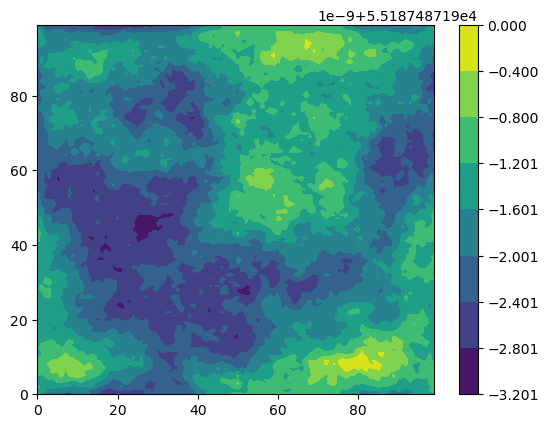

In [471]:
ctf = plt.contourf(Temperature_Grid_2[3])
plt.colorbar()

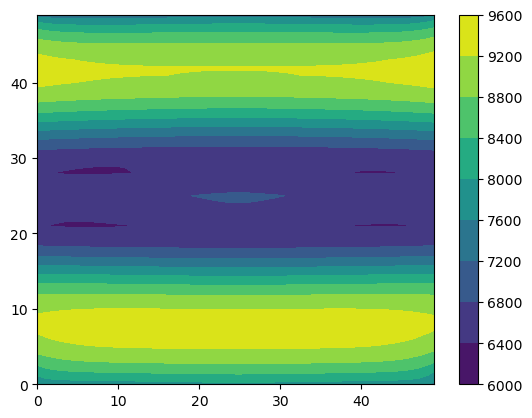

In [124]:
ctf = plt.contourf(Temperature_Grid_2[50])
plt.colorbar()

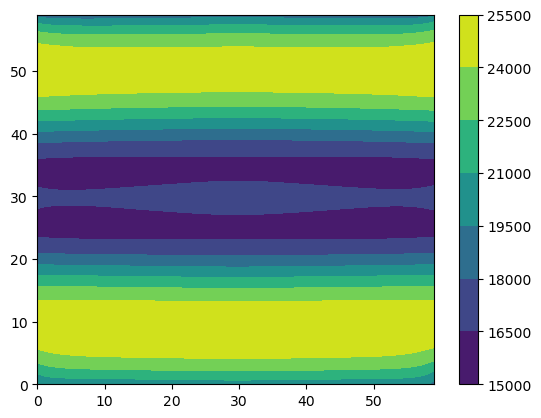

In [222]:
ctf = plt.contourf(Temperature_Grid_2[2])
plt.colorbar()

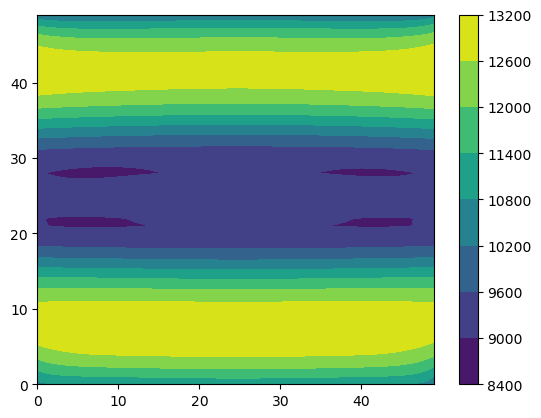

In [97]:
ctf = plt.contourf(Temperature_Grid_2[70])
plt.colorbar()

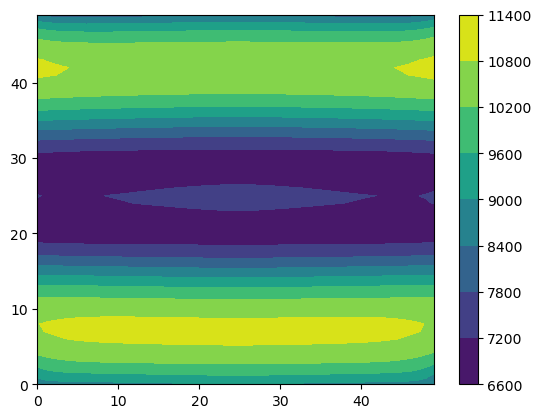

In [40]:
ctf = plt.contourf(Temperature_Grid_2[10])
plt.colorbar()

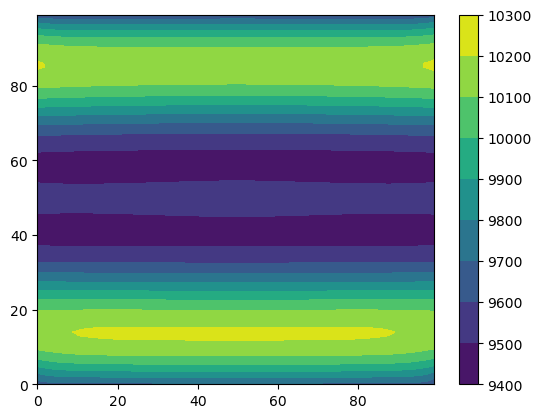

In [503]:
ctf = plt.contourf(Temperature_Grid_2[100])
plt.colorbar()

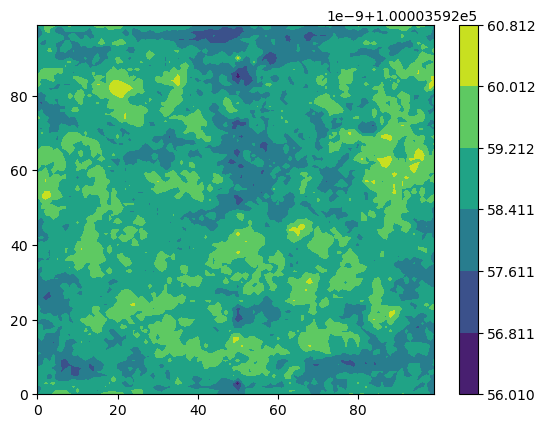

In [478]:
ctf = plt.contourf(Temperature_Grid_2[50])
plt.colorbar()

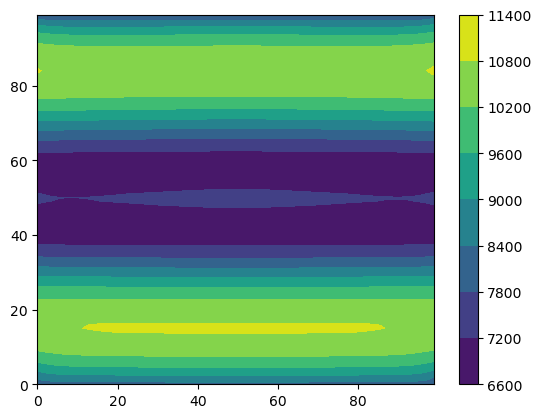

In [54]:
ctf = plt.contourf(Temperature_Grid_2[10])
plt.colorbar()

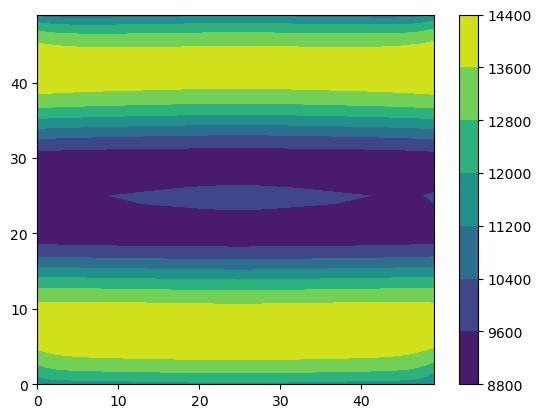

In [143]:
ctf = plt.contourf(Temperature_Grid_2[10])
plt.colorbar()

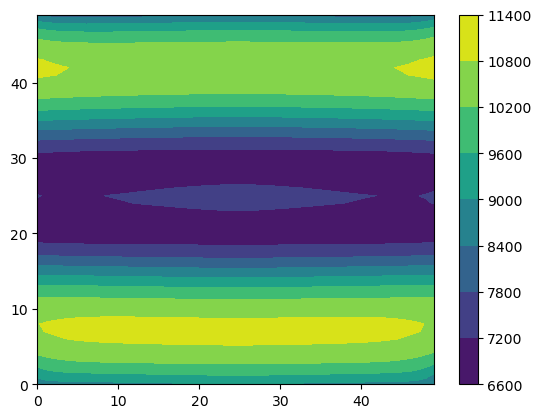

In [125]:
ctf = plt.contourf(Temperature_Grid_2[10])
plt.colorbar()